# 1. Giriş

Zaman serileri yazı dizimizde, tanımından başlayıp doğrusal ve varsayımlara dayalı öngörü modellerine ve çok değişkenli öngörü modellerine kadar farklı konuları ele aldık. Bu son yazıda ise bazı güncel öngörü yaklaşımlarına göz atacağız. Bu yaklaşımlar, genel olarak doğrusal modellerin varsayımlarını içermez. Fakat model karmaşıklığı da bir o kadar fazladır.

# 2. Hiyerarşik Zaman Serisi Öngörü Modelleri

Zaman serileri öngörüsü ile ilgili çalışmaların çoğu, belirli bir toplulaştırma düzeyine odaklanmaktadır. Ancak, aynı serileri daha ayrıntılı bir düzeyde gözlemlemek için toplulaştırılmış verileri detaylandırabildiğimiz zaman zorluklar ortaya çıkar. Böyle bir durumda, genellikle daha düşük düzeyler için öngörülerin toplulaştırılmış öngörülerine dahil lmadığını görebiliriz - bunlar tutarlı değildir. Durumun böyle olmadığından emin olmak için **hiyerarşik zaman serileri (hierarchical time series-HTS) öngörüleri** adı verilen bir yaklaşım kullanabiliriz.

Hiyerarşik zaman serileri genellikle coğrafi bölünmeler nedeniyle ortaya çıkar. Örneğin, toplam alkol satışları ülkeye göre, ardından her ülke içinde bölgeye göre, bölge içinde illere ve bu şekilde başlangıç seviyesine kadar ayrıştırılabilir. Aşağıdaki hiyerarşik yapıyı ele alalım:

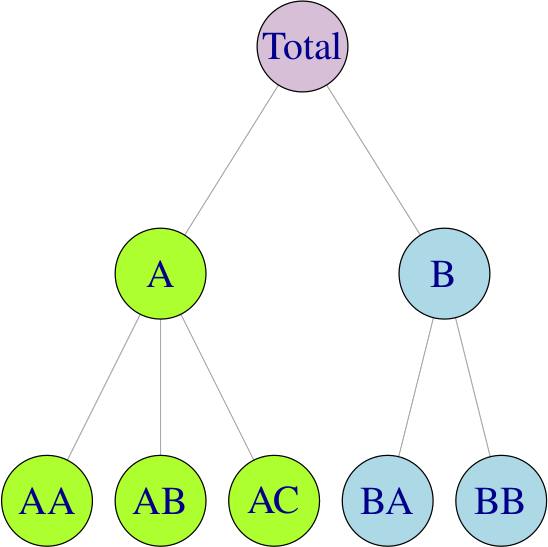

Herhangi bir $t$ zamanı için, hiyerarşinin en alt seviyesindeki gözlemler, yukarıdaki serinin gözlemlerini toplulaştıracaktır. Örneğin,

$$
y_{t}=y_{\mathrm{AA}, t}+y_{\mathrm{AB}, t}+y_{\mathrm{AC}, t}+y_{\mathrm{BA}, t}+y_{\mathrm{BB}, t}
$$
$$
y_{\mathrm{A}, t}=y_{\mathrm{AA}, t}+y_{\mathrm{AB}, t}+y_{\mathrm{AC}, t} \quad \text { ve } \quad y_{\mathrm{B}, t}=y_{\mathrm{BA}, t}+y_{\mathrm{BB}, t}
$$

ikinci denklemi, birincide yerine koyarsak: $y_{t}=y_{\mathrm{A}, t}+y_{\mathrm{B}, t}$

Burada önemli bir husus, hiyerarşik zaman serisi öngörülerinin kendi başına bir zaman serisi öngörü (ARIMA, ETS veya Prophet gibi) yöntemi olmadığıdır. Bunun yerine, verilen bir tekil zaman serileri hiyerarşisinde öngörüleri tutarlı kılan farklı tekniklerin bir birleşimidir. Bu noktada, dört yaklaşımdan bahsetmek uygun olur:

* **Aşağıdan yukarıya yaklaşımda**, hiyerarşinin en altındaki seviyesi öngörülür ve daha sonra daha yüksek seviyeler için öngörüler oluşturmak için öngörüler birleştirilir.
* **Yukarıdan aşağıya yaklaşım**, hiyerarşinin en üst seviyesini öngörmeyi ve ardından da öngörüyü daha lat düzeydeki serilere bölmeyi içerir.
* **Ortadan dışa yaklaşımı**, yukarıda açıklanan iki yöntemin bir kombinasyonudur ve yalnızca katı hiyerarşik zaman serileri için kullanılabilir. Bu yaklaşımda orta seviyeyi seçip doğrudan öngörü yapılır. Sonra da, yukarıdaki iki yaklaşımla öngörüler gerçekleştirilir.
* Yukarıda açıklanan üç yaklaşım, zaman serilerini tek bir düzeyde öngörmeye ve ardından bunları geri kalan düzeyleri çıkarmak için kullanmaya odaklanır. Bunların aksine, **optimal uzlaşma (optimal reconciliation)** yönteminde, verilen hiyerarşinin sunabileceği tüm bilgileri ve ilişkileri kullanarak seviyelerin her birini tahmin ederiz.

***Örnek: Avustralya Çeyreklik Turizm Hacmi***

Örnek olarak 1998 ve 2016 dönemi için, Avustralya'ya ait bölge, eyalet ve amaç düzeyinde gözlemlenmiş turizm hacmi   [verileri](https://www.kaggle.com/luisblanche/quarterly-tourism-in-australia) ile hiyerarşik zaman serileri öngörü modelini oluşturacağız. Model için `scikit-hts` çerçevesini kullanacağız. 

In [1]:
import warnings
warnings.filterwarnings("ignore")

# gerekli çerçevelerlin içeri alınması
import pandas as pd
import numpy as np
import hts

import matplotlib.pyplot as plt
import seaborn as sns

Veriyi içeri alıp düzenleyelim:

In [2]:
# load the data 
turizm_verisi = pd.read_csv("tourism.csv").drop(columns=["Unnamed: 0"])
# değişken isimlerini küçük harfe dönüştürme
turizm_verisi.columns = [col_name.lower() for col_name in turizm_verisi.columns]
# turizm amacı bazında gezintilerin toplanması
turizm_verisi = turizm_verisi.groupby(["quarter", "region", "state"])["trips"] \
                             .sum() \
                             .reset_index(drop=False)
# bölge isimlerinin temizlenmesi 
turizm_verisi["region"] = turizm_verisi["region"].apply(lambda x: x.replace(" ", "_").replace("'", ""))
# eyalet isimlerinin kısaltmaya dönüştürülmesi
kısaltma_haritası = {
    "New South Wales": "NSW",
    "Northern Territory": "NT",
    "Queensland": "QLD",
    "South Australia": "SA",
    "Victoria": "VIC",
    "Western Australia": "WA",
    "ACT": "ACT",
}
turizm_verisi["state"] = turizm_verisi["state"].map(kısaltma_haritası)
# alt seviye için id oluşturulması
turizm_verisi["state_region"] = turizm_verisi.apply(lambda x: f"{x['state']}_{x['region']}", axis=1)

Düzenlemelerden sonra verinin görünüşü:

In [3]:
print(turizm_verisi.head())

      quarter                     region state       trips  \
0  1998-01-01                   Adelaide    SA  658.553895   
1  1998-01-01             Adelaide_Hills    SA    9.798630   
2  1998-01-01              Alice_Springs    NT   20.207638   
3  1998-01-01     Australias_Coral_Coast    WA  132.516409   
4  1998-01-01  Australias_Golden_Outback    WA  161.726948   

                   state_region  
0                   SA_Adelaide  
1             SA_Adelaide_Hills  
2              NT_Alice_Springs  
3     WA_Australias_Coral_Coast  
4  WA_Australias_Golden_Outback  


Bir sonraki adım için `scikit-hts` çerçevesi için veriyi hazırlayalım:

In [4]:
# alt seviye verisi
alt_seviye = turizm_verisi.pivot(index="quarter", columns="state_region", values="trips")
# orta seviye verisi
orta_seviye = turizm_verisi.groupby(["quarter", "state"]) \
                           .sum() \
                           .reset_index(drop=False) \
                           .pivot(index="quarter", columns="state", values="trips")
# üst seviye verisi
üst_seviye = turizm_verisi.groupby("quarter")["trips"] \
                          .sum() \
                          .to_frame() \
                          .rename(columns={"trips": "total"})

# veri çerçevelerinin birleştirilmesi
hiyerarşik_veri       = alt_seviye.join(orta_seviye).join(üst_seviye)
hiyerarşik_veri.index = pd.to_datetime(hiyerarşik_veri.index)
hiyerarşik_veri       = hiyerarşik_veri.resample("QS").sum()

Hiyerarşi nesnesini oluşturalım:

In [5]:
eyaletler = turizm_verisi["state"].unique()
bölgeler  = turizm_verisi["state_region"].unique()
toplam    = {'total': list(eyaletler)}
eyalet    = {k: [v for v in bölgeler if v.startswith(k)] for k in eyaletler}
hiyerarşi = {**toplam, **eyalet}

Hiyerarşik yapıyı görmek için ağaç yapısını çizelim:

In [6]:
ağaç = hts.hierarchy.HierarchyTree.from_nodes(hiyerarşi, hiyerarşik_veri, root='total')
print(ağaç)

- total
   |- SA
   |  |- SA_Adelaide
   |  |- SA_Adelaide_Hills
   |  |- SA_Barossa
   |  |- SA_Clare_Valley
   |  |- SA_Eyre_Peninsula
   |  |- SA_Fleurieu_Peninsula
   |  |- SA_Flinders_Ranges_and_Outback
   |  |- SA_Kangaroo_Island
   |  |- SA_Limestone_Coast
   |  |- SA_Murraylands
   |  |- SA_Riverland
   |  - SA_Yorke_Peninsula
   |- NT
   |  |- NT_Alice_Springs
   |  |- NT_Barkly
   |  |- NT_Darwin
   |  |- NT_East_Coast
   |  |- NT_Hobart_and_the_South
   |  |- NT_Kakadu_Arnhem
   |  |- NT_Katherine_Daly
   |  |- NT_Lasseter
   |  |- NT_Launceston,_Tamar_and_the_North
   |  |- NT_MacDonnell
   |  |- NT_North_West
   |  |- NT_Tasmania
   |  - NT_Wilderness_West
   |- WA
   |  |- WA_Australias_Coral_Coast
   |  |- WA_Australias_Golden_Outback
   |  |- WA_Australias_North_West
   |  |- WA_Australias_South_West
   |  - WA_Experience_Perth
   |- VIC
   |  |- VIC_Ballarat
   |  |- VIC_Bendigo_Loddon
   |  |- VIC_Central_Highlands
   |  |- VIC_Central_Murray
   |  |- VIC_Geelong
   |

Yukarıdan aşağıya yaklaşımla, `auto_arima` yöntemiyle 4 dönemlik öngörüleri gerçekleştirelim:

In [7]:
model_arima = hts.HTSRegressor(model="auto_arima", revision_method='AHP', n_jobs=0)
model_arima = model_arima.fit(hiyerarşik_veri, hiyerarşi)
arima_öngörüleri = model_arima.predict(steps_ahead=4)

Fitting models: 100%|█████████████████████████████████████████████████████████████████| 85/85 [00:00<00:00, 303.80it/s]


Öngörüleri çizelim:

In [16]:
#arima_öngörüleri

# 3. Bayesyen Yaklaşıma Dayanan Öngörü Modelleri

Bayesyen yaklaşım, belirsizliği azaltmak ve önsel (prior) bilgiyi biraraya getirmek için zaman serilerine olasılıksal bir yaklaşım sunar. Bu modeller **Dinamik Doğrusal Modeller** veya **Yapısal Zaman Serileri (durum uzay modelleri)** olarak da adlandırılır. Bir zaman serisindeki yapısal değişiklikleri dinamik olarak uydurarak (fit) çalışırlar - başka bir deyişle, yeni bilgilerin eklenmesiyle model parametrelerini zaman içinde geliştirip güncellerler. Buna karşılık, ARIMA, sabit kalan seriler için parametreleri tahmin eder ve daha sonra zaman serisi öngörülerini belirlemek için Maksimum Olabilirlik tahminini kullanır. Bayes yöntemleri, dağılımlardan tahminler oluşturmak için MCMC'yi (Monte Carlo Markov Zincirleri-Monte Carlo Markov Chains) kullanır.

Aşağıdaki özbağlanımlı süreci düşünelim:

$$
Y_{t}=a+\beta_{1} Y_{t-1}+\beta_{2} Y_{t-2}+\ldots+\beta_{p} Y_{t-p}+\varepsilon_{t}
$$

Seriyi trendden arındırdığımızda:

$$
Y_{t}=a+\Phi_{1} \varepsilon_{t-1}+\Phi_{2} \varepsilon_{t-2}+\ldots+\Phi_{q} \varepsilon_{t-q}
$$

ARIMA ile bu süreci modellemiş olsaydık, a parametresine bağlı olduğumuzu görebiliriz. 

Spesifik olarak, bayesyen model, zaman serimizi oluşturan gerçek dünyaya ilişkin gözlemlerimizin ($y_{t}$), bir Markov sürecine göre (her bir durumun bağımlı olduğu bir süreç) zaman içinde gelişen gizli bir durumun ($\alpha_{t}$) bir fonksiyonu olarak belirlendiğini belirtir. Bayesyen yapısal zaman serimizi bir dizi denklem ile ifade edebiliriz:

$$y_{t}=Z_{t}^{\top} \alpha_{t}+\epsilon_{t}, \epsilon_{t} \sim N\left(0, H_{t}\right)$$
$$\alpha_{t+1}=T_{t} \alpha_{t}+R_{t} \eta_{t}, \eta t \sim N\left(0, Q_{t}\right)$$

Gizli durumumuzu (hidden state) gözlemlenen durumumuza (observed state) bağladığı için ilk gözlem denklemini ve her bir iç durumu bir önceki iç duruma bağladığı için geçiş (transition) denklemini etiketliyoruz. Yukarıda açıklanan ARIMA modeli de dahil olmak üzere birçok farklı model bu formda ifade edilebilir.

Python ile bayesyen zaman serileri öngörü modelleri oluşturmak için birçok çerçeve mevcuttur: `tensorflow-probability`, `pyro`, `PyBATS`, `GluonTS`, `DeepAR`, `prophet`, `darts` ve `orbit-ml` bu çerçevelerden bazılarıdır. Burada bir örnek vermek amacıyla `orbit-ml` çerçevesini kullanacağız. İlgilenenler için, sayılan çerçevelerin kullanıcı rehberleri daha detaylı fikir sağlayacaktır.

***Örnek: iclaims verisi***

iclaims verileri, Ocak 2010 - Haziran 2018 arasında birkaç ilgili google trend sorgusuna (işsizlik, doldurma ve iş) karşı ABD işsizlik yardımları için haftalık ilk talepleri içerir. St. Louis Federal Rezerv Bankası'ndan talep sayısı alınırken, google sorguları gibi açıklayıcı değişkenler de Google Trends API üzerinden elde edilmiştir. Hem açıklanan hem de açıklayıcı değişkenler, çarpımsal bir modeli göstermek için logaritmik dönüşüm yapılmıştır. İlgili çerçeveleri içeri alalım:

In [8]:
import orbit
from orbit.utils.dataset import load_iclaims
from orbit.models import ETS
from orbit.diagnostics.plot import plot_predicted_data

Şimdi, veriyi çalışma ortamına alalım:

In [9]:
# verinin alınması
veri = load_iclaims()
tarih_değişkeni = 'week'
hedef_değişken  = 'claims'

# veri hakkında bilgi
veri.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 443 entries, 0 to 442
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   week            443 non-null    datetime64[ns]
 1   claims          443 non-null    float64       
 2   trend.unemploy  443 non-null    float64       
 3   trend.filling   443 non-null    float64       
 4   trend.job       443 non-null    float64       
 5   sp500           443 non-null    float64       
 6   vix             443 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 27.7 KB


Verinin görünümü:

In [10]:
print(veri.head())

        week     claims  trend.unemploy  trend.filling  trend.job     sp500  \
0 2010-01-03  13.386595        0.219882      -0.318452   0.117500 -0.417633   
1 2010-01-10  13.624218        0.219882      -0.194838   0.168794 -0.425480   
2 2010-01-17  13.398741        0.236143      -0.292477   0.117500 -0.465229   
3 2010-01-24  13.137549        0.203353      -0.194838   0.106918 -0.481751   
4 2010-01-31  13.196760        0.134360      -0.242466   0.074483 -0.488929   

        vix  
0  0.122654  
1  0.110445  
2  0.532339  
3  0.428645  
4  0.487404  


Veriyi bölüp, modeli oluşturalım:

In [11]:
# verinin bölünmesi
test_hacmi = 52
eğitim_verisi = veri[:-test_hacmi]
test_verisi   = veri[-test_hacmi:]

# modelin oluşturulması
ets = ETS(
    response_col=hedef_değişken,
    date_col=tarih_değişkeni,
    seasonality=52,
    seed=8888,
)

# modelin çalışması
ets.fit(df=eğitim_verisi)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Test verisi için öngörüleri yapalım:

In [12]:
öngörü_verisi = ets.predict(df=test_verisi)

Öngörülerin grafiğini çizelim:

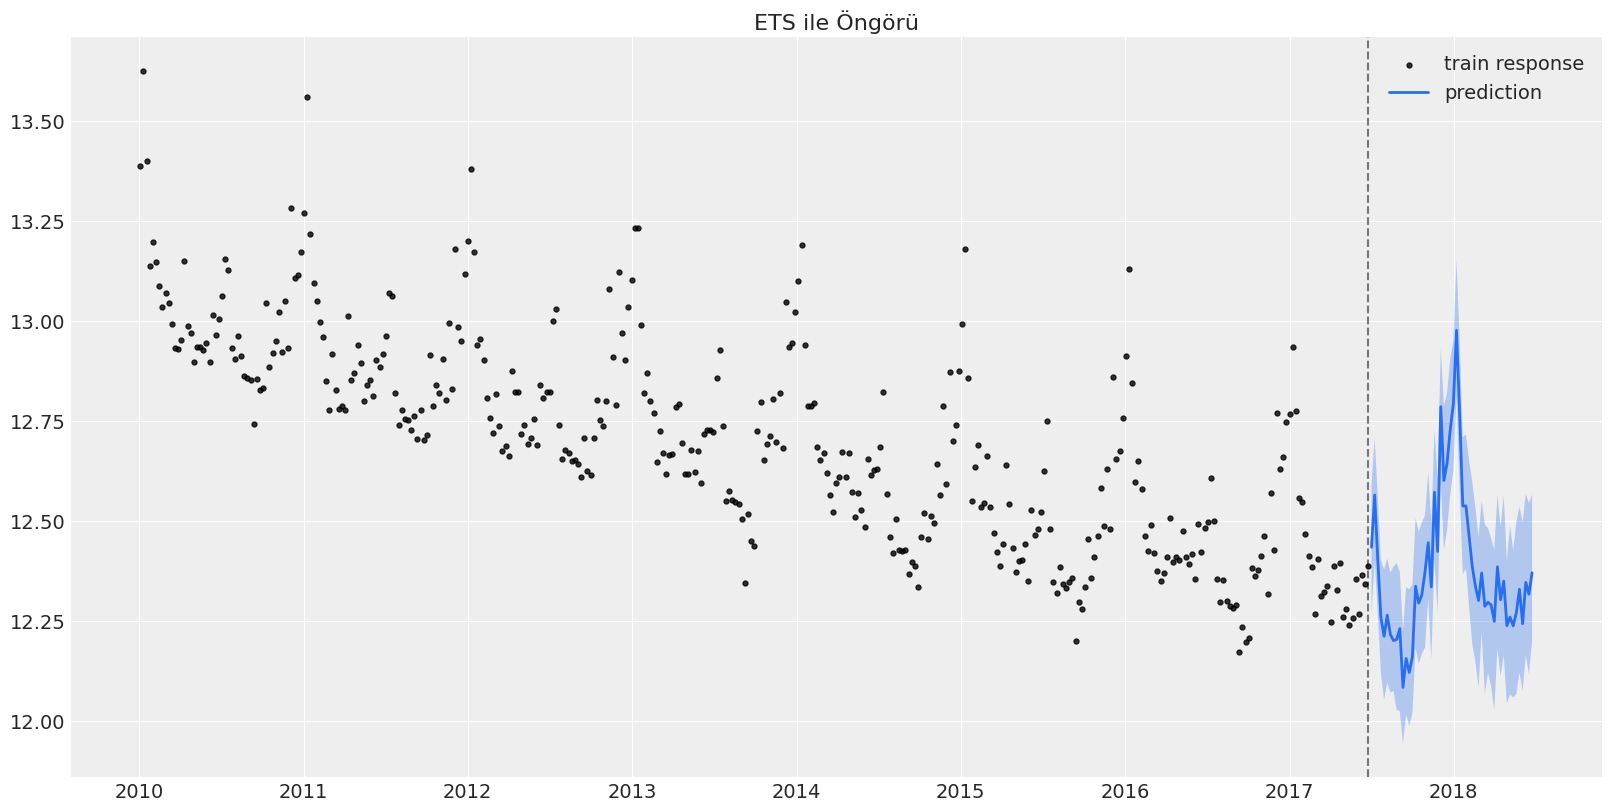

In [17]:
_ = plot_predicted_data(eğitim_verisi, öngörü_verisi, tarih_değişkeni, hedef_değişken, title='ETS ile Öngörü', use_orbit_style=False)

Sonsal (posterior) örneklemleri çıkaralım:

In [14]:
sonsal_örneklemler = ets.get_posterior_samples()
sonsal_örneklemler.keys()

odict_keys(['l', 'lev_sm', 'obs_sigma', 's', 'sea_sm'])

Sonsal örneklem parametrelerini çizelim:

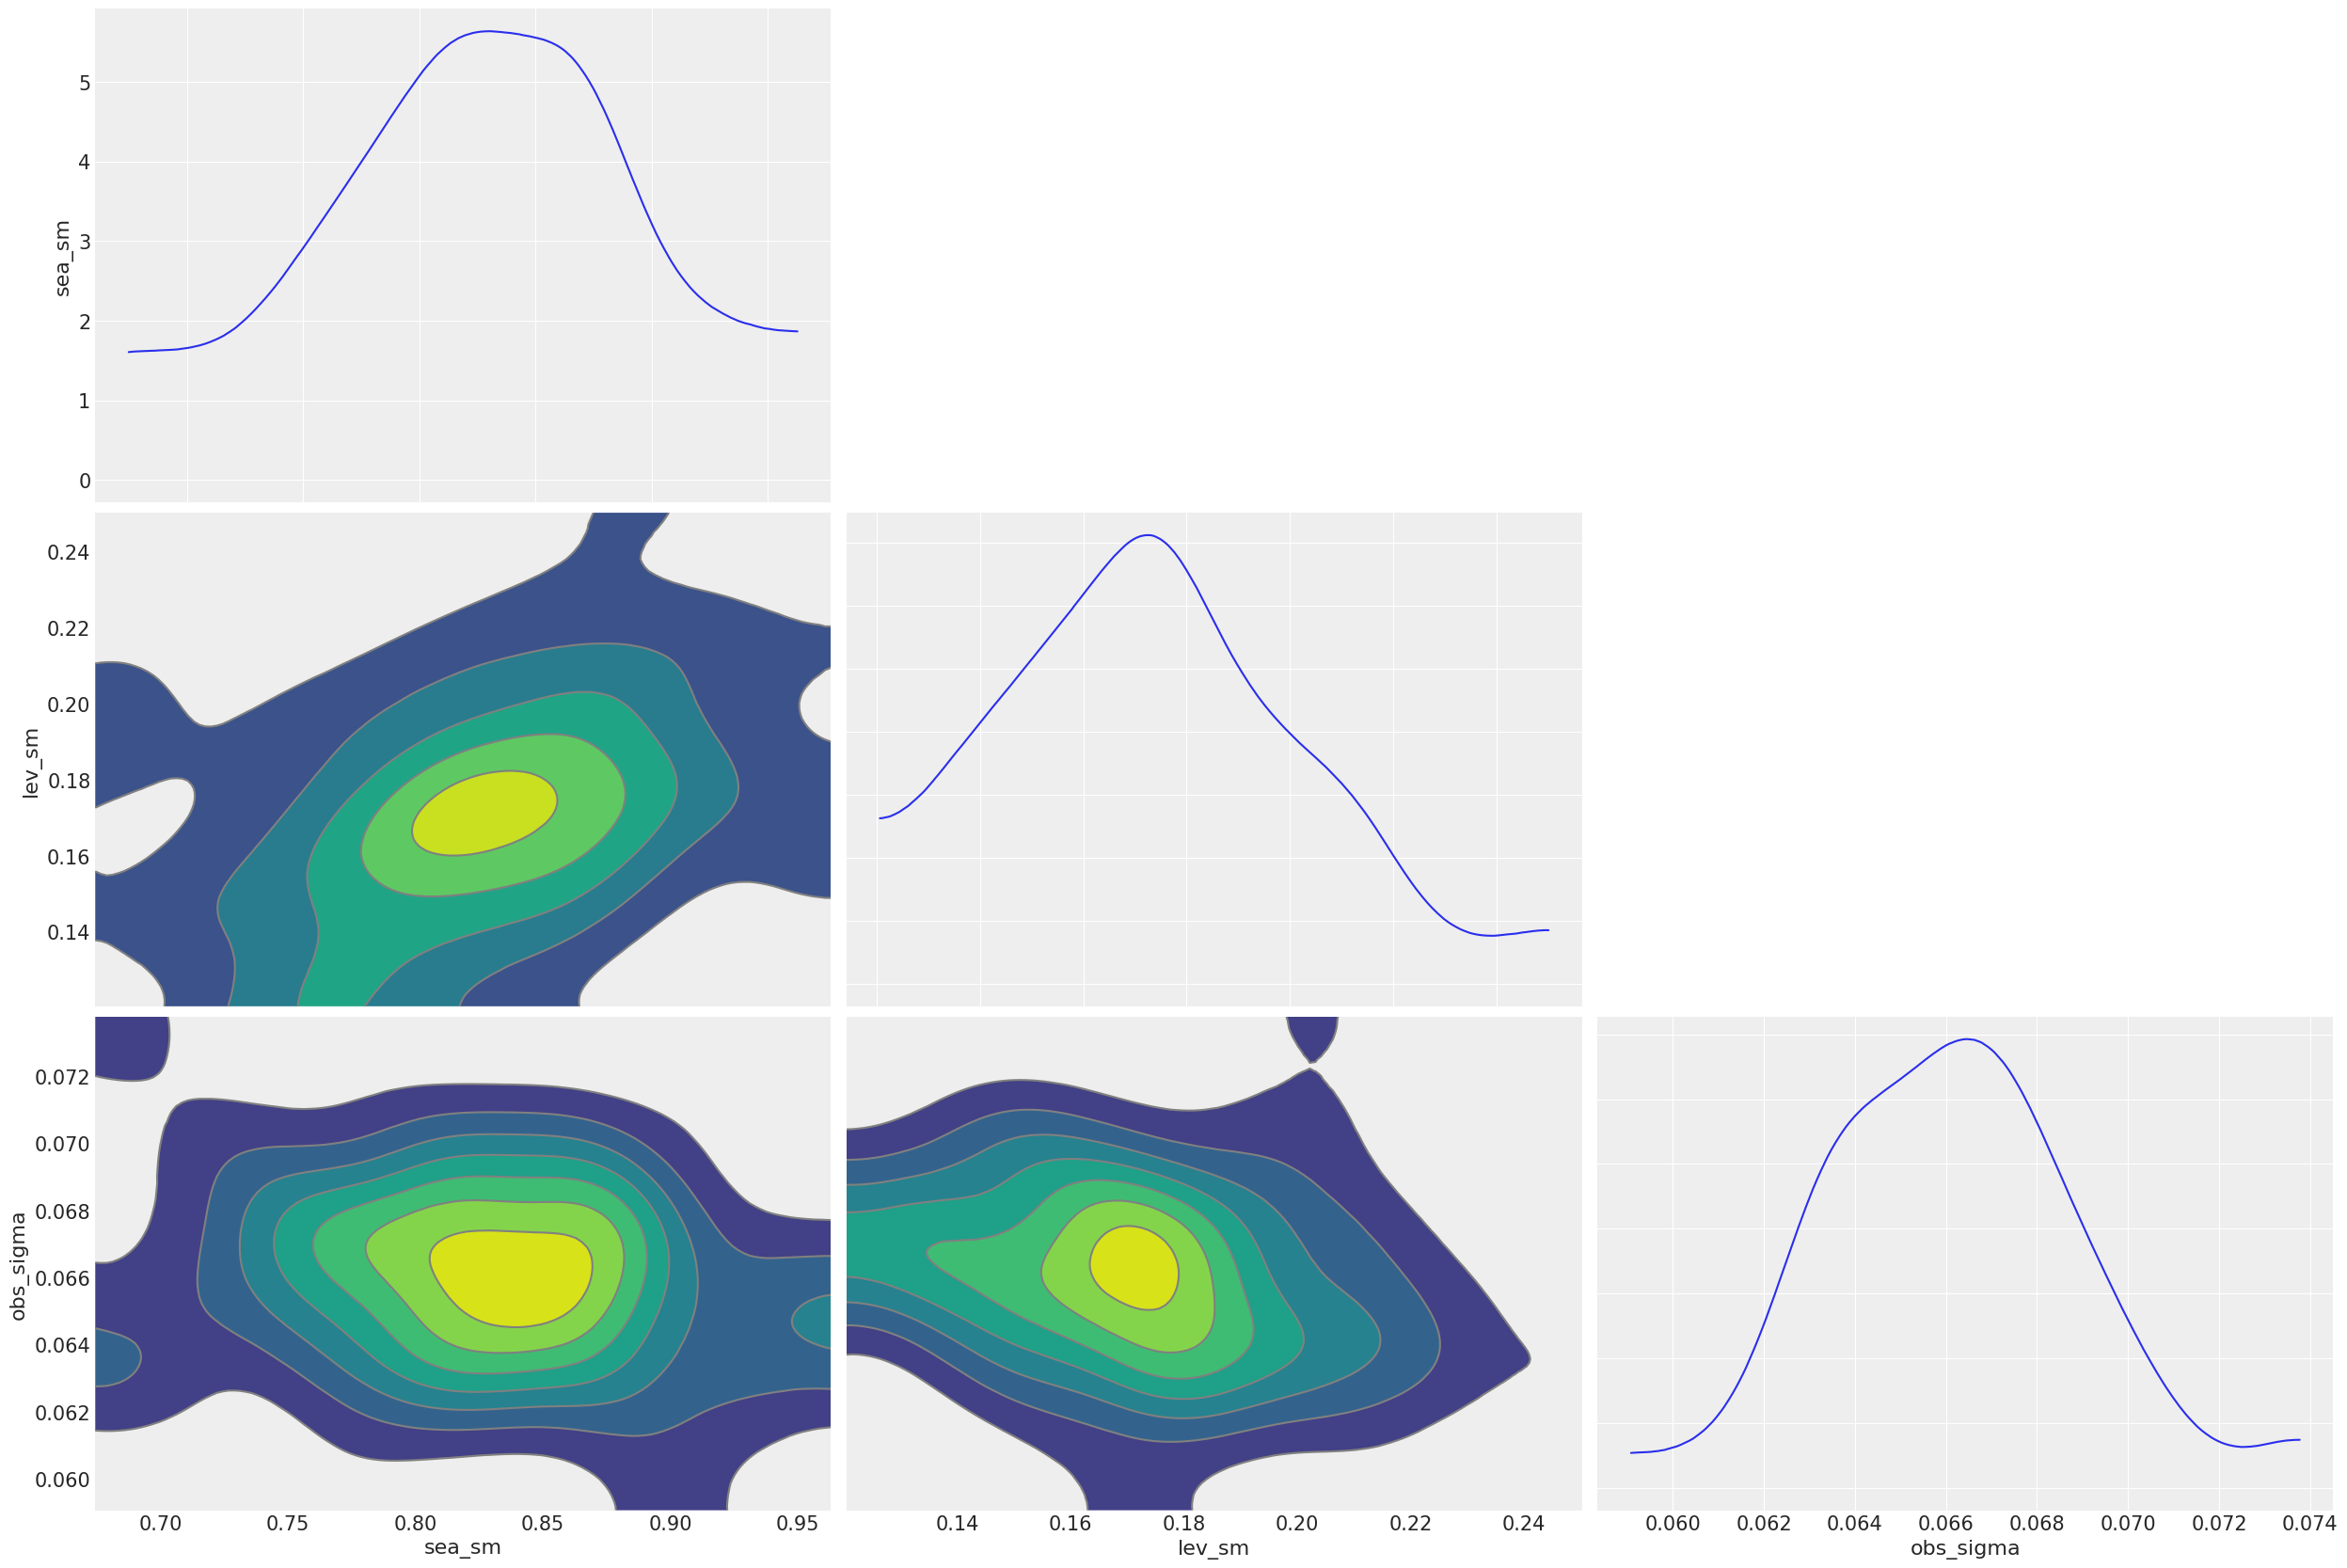

In [15]:
import arviz as az

sonsal_örneklemler = ets.get_posterior_samples(permute=False)

# example from https://arviz-devs.github.io/arviz/index.html
az.style.use("arviz-darkgrid")
az.plot_pair(
    sonsal_örneklemler,
    var_names=["sea_sm", "lev_sm", "obs_sigma"],
    kind="kde",
    marginals=True,
    textsize=15,
)
plt.show()

# 4. Yapay Öğrenme Algoritmaları ile Öngörü

Yakın zamanlarda, yapay öğrenme modelleri, zaman serisi öngörülerinde dikkat çekti ve öngörü alanında klasik istatistiksel modellere ciddi rakip olarak yerleşti. Özbağlanımlı bir zaman serisi modeli aşağıdaki gibi yazılabilir:

$$
y_{t}=f\left(y_{t-d}, y_{t-d-1}, \ldots, y_{t-d-n+1}\right)+w(t)
$$

Böyle bir zaman serisi modelini yapay öğrenme algoritmaları ile modelleyebilmek için birkaç farklı yaklaşım mevcuttur (Bontempi vd., 2013):

* Tek dönemlik öngörü: Gözetimli öğrenme, Yerel öğrenme ile örnekleme
* Çok dönmelik öngörü: Özyinelemeli strateji, doğrudan strateji, özyinelemeli ve doğrudan hibrit strateji
* Çok çıktılı öngörü

***Örnek: Havayolu Yolcu Sayısı Öngörü Modeli***

Daha önceki yazılarda örnek olarak çalıştığımız AirPassengers verileri için LightGBM algoritması ile öngörüler oluşturalım. Bunun için `darts` çerçevesi bize kolaylık sağlar:

In [19]:
from darts import TimeSeries

# verinin içeri alınması
veri = pd.read_csv('AirPassengers.csv', delimiter=",")

# TimeSeries nesnesi oluşturulması
zaman_serisi = TimeSeries.from_dataframe(veri, 'Month', '#Passengers')

# son 36 ayı test verisi olarak ayıralım
eğitim_verisi, test_verisi = zaman_serisi[:-36], zaman_serisi[-36:]

Modeli oluşturalım:

In [27]:
from darts.models import LightGBMModel

# modelin oluşturulması
model = LightGBMModel(lags=12)

# modelin uydurulması
model.fit(eğitim_verisi)

# öngörülerin alınması
öngörüler = model.predict(len(test_verisi))

%5 ve %95 yüzdelikler içinde öngörülerin ve gerçek verinin çizilmesi:

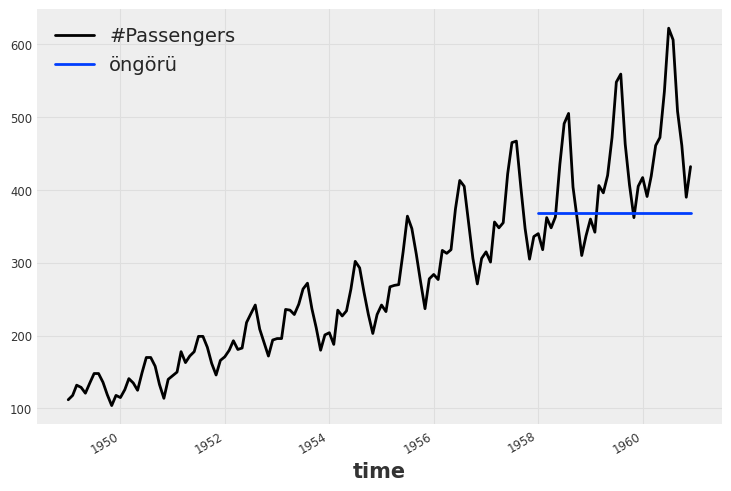

In [28]:
zaman_serisi.plot()
öngörüler.plot(label='öngörü', low_quantile=0.05, high_quantile=0.95)
plt.legend();

Öngörüler, varsayılan model parametreleri ile çok tutarlı görünmese de, çalışmayı görmek adına yeterlidir. Farklı model parametreleri ile daha tutarlı öngörüler türetilebilir.

Yapay öğrenme yaklaşımlarıyla öngörülerden bahsetmişken, özel olarak N-BEATS ve Transformers yaklaşımlarından da bahsetmek yerinde olacaktır. İzleyen altbölümlerde bu yaklaşımları ele alacağız.

## 4.1. N-BEATS Modeli

Oreshkin vd.(2019) çalışmasına dayanan model, M4 veri kümesi tarafından temsil edilen tek değişkenli zaman serisi öngörü görevleri kümesinde istatistiksel modellerden ve bunların yapay öğrenme ile kombinasyonlarından daha iyi performans göstermek için saf bir derin öğrenme modeli olarak ortaya atılmıştır. Modelin genel yapısı aşağıdaki gibidir:

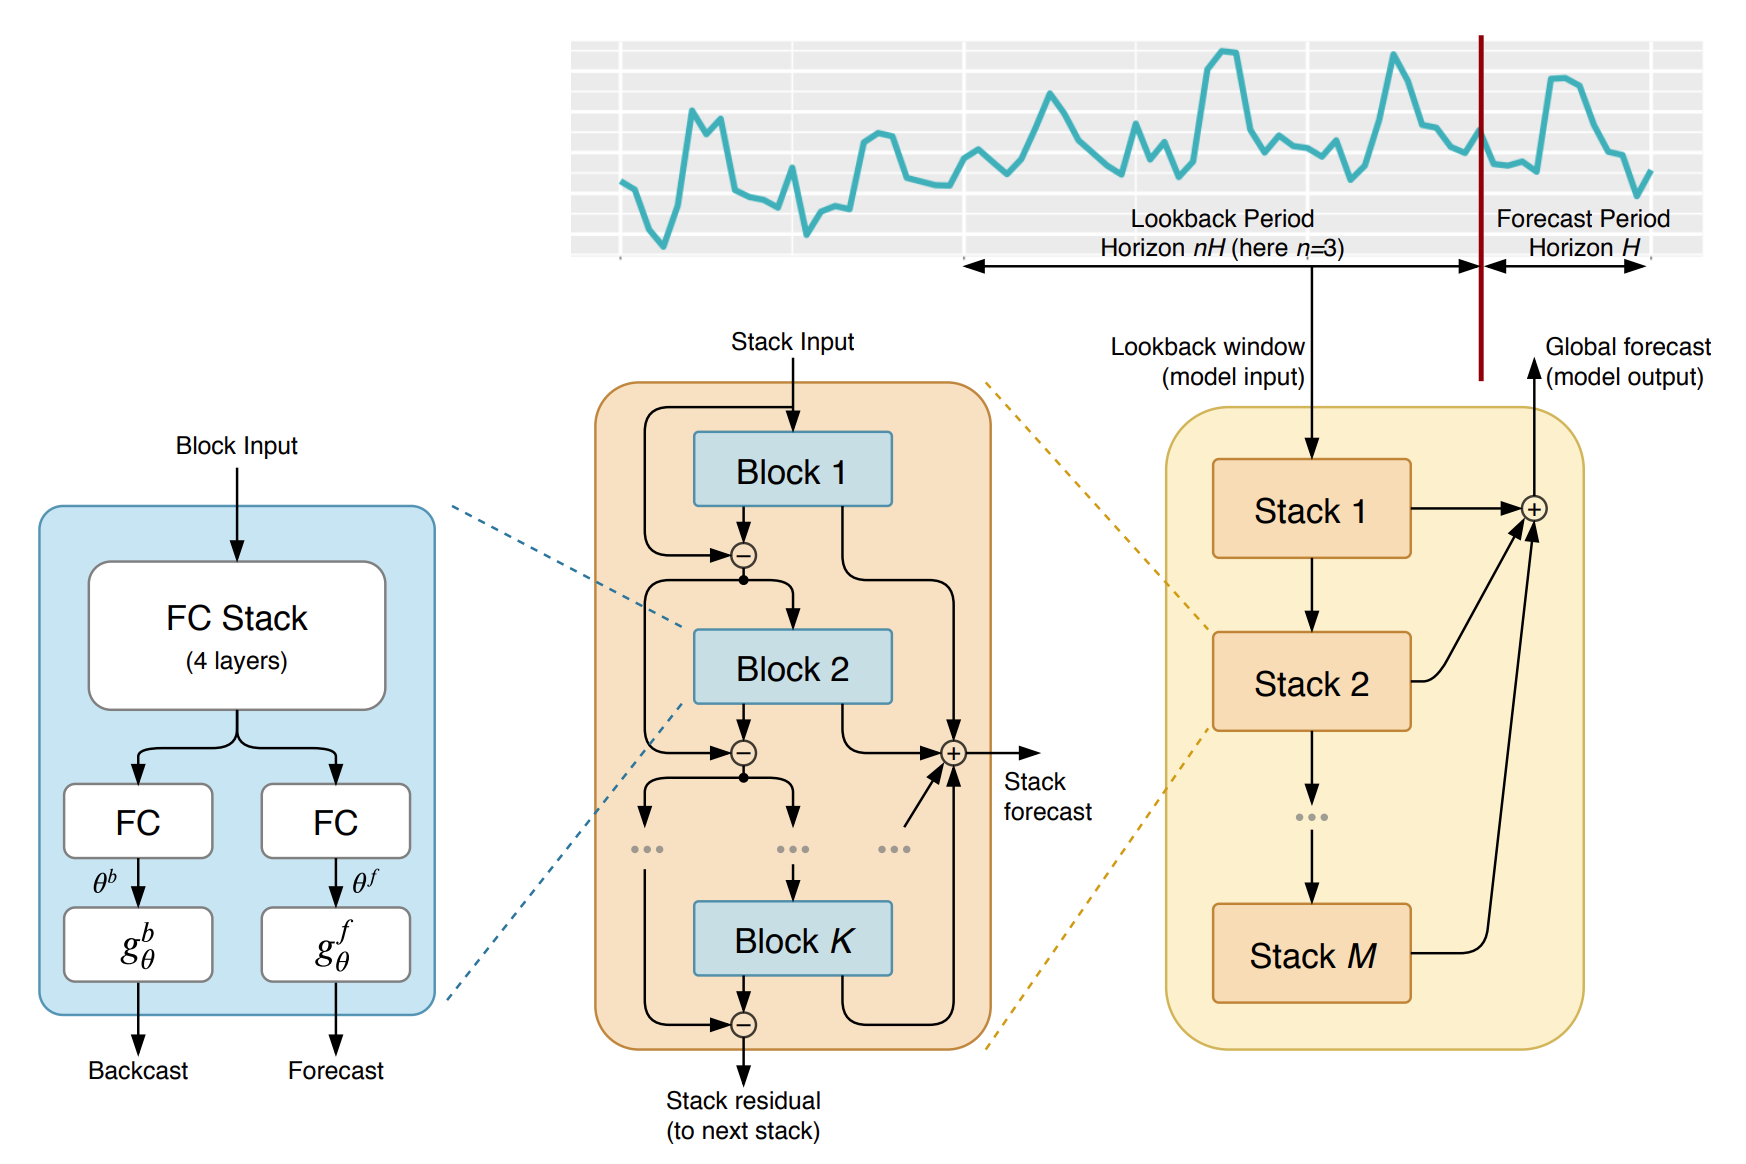

***Örnek: Havayolu Yolcu Sayıları için NBEATS Öngörü Modeli***

Önceki örnekte ele aldığımız veri için, yine `darts` çerçevesi ile NBEATS öngörü modelinin hızlı bir uygulamasını gerçekleştirelim:

In [29]:
from darts.models import NBEATSModel
from darts.metrics import mape, smape

# modelin oluşturulması
model = NBEATSModel(
        input_chunk_length=24, 
        output_chunk_length=12, 
        n_epochs=200, 
        random_state=0
)

# modelin uydurulması
model.fit(eğitim_verisi, verbose=True)

[2022-02-05 16:57:53,207] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 73 samples.
[2022-02-05 16:57:53,207] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 73 samples.
INFO:darts.models.forecasting.torch_forecasting_model:Train dataset contains 73 samples.
[2022-02-05 16:57:53,277] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-02-05 16:57:53,277] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
INFO:darts.models.forecasting.torch_forecasting_model:Time series values are 64-bits; casting model to float64.


  0%|          | 0/200 [00:00<?, ?it/s]

Öngörüleri ve gerçek değerleri çizelim:

MAPE = 13.03%


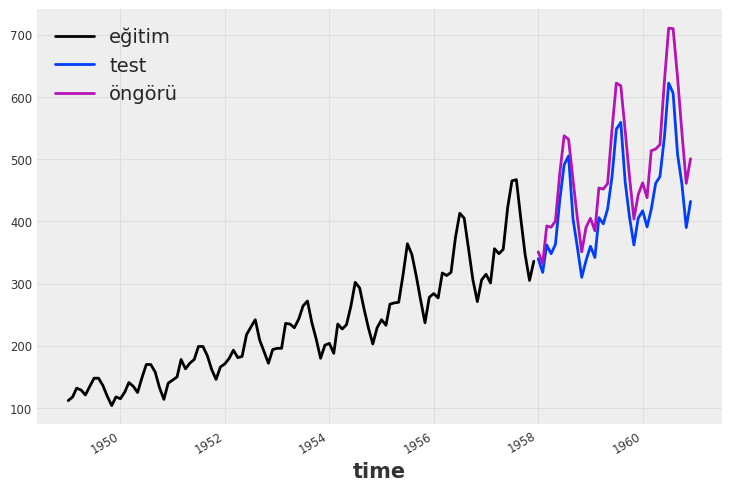

In [34]:
öngörüler = model.predict(n=36, series=eğitim_verisi)

eğitim_verisi.plot(label="eğitim")
test_verisi.plot(label="test")
öngörüler.plot(label="öngörü")
plt.legend()
print("MAPE = {:.2f}%".format(mape(test_verisi, öngörüler)))

## 4.2. Dönüştürücü (Transformers) Modeller

Bu yaklaşım, zaman serisi verilerinden karmaşık kalıpları ve dinamikleri öğrenmek için öz-dikkat (self-attention) mekanizmalarından yararlanarak çalışır. Ayrıca, genel bir çerçevedir ve tek değişkenli ve çok değişkenli zaman serisi verilerine ve ayrıca zaman serisi yerleştirmelerine (embedding) uygulanabilir (Wu vd, 2020). Aşağıda, model mimarisi gösterilmiştir:

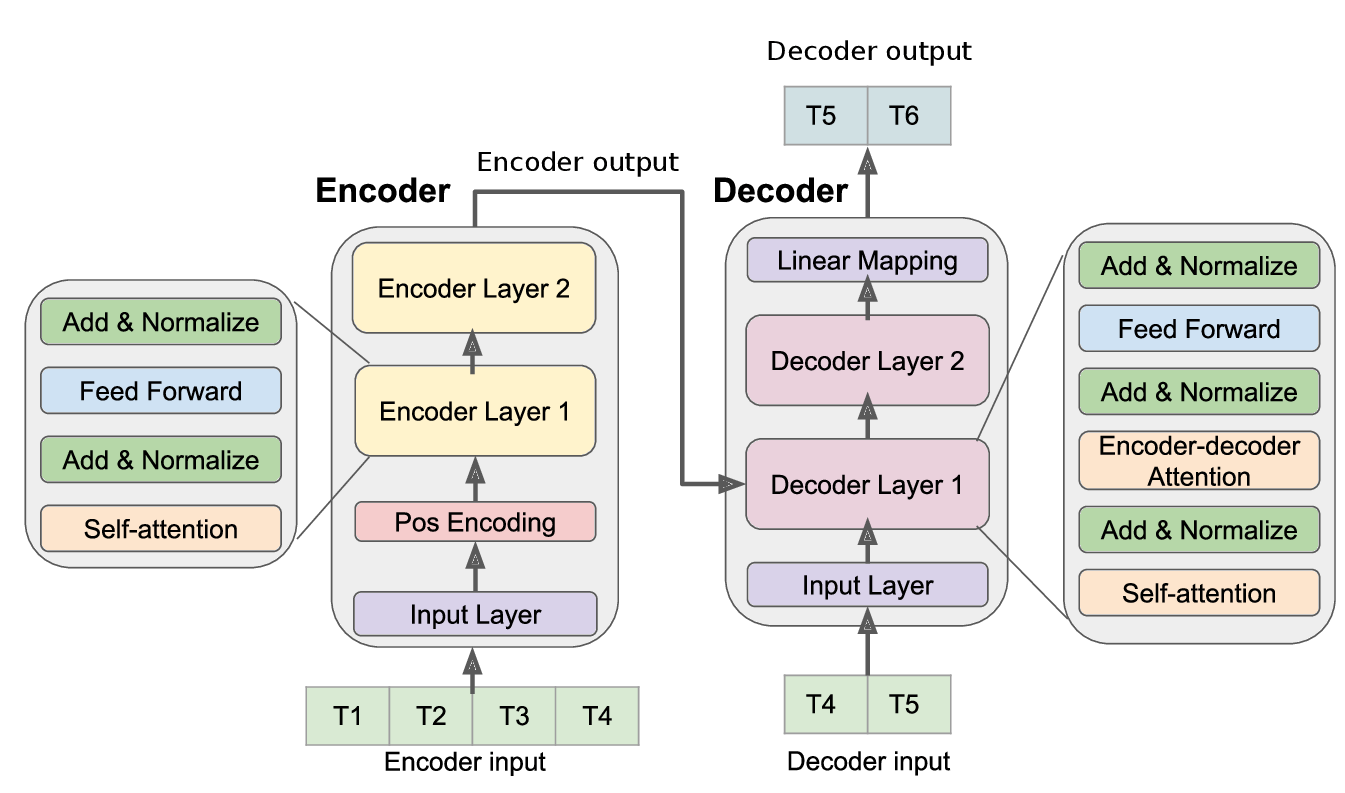

In [42]:
from darts.models import TransformerModel
from darts.dataprocessing.transformers import Scaler

# verinin ölçeklenmesi
ölçekleyici = Scaler()
ölçeklenmiş_eğitim_verisi = ölçekleyici.fit_transform(eğitim_verisi)
ölçeklenmiş_test_verisi   = ölçekleyici.transform(test_verisi)
ölçeklenmiş_veri = ölçekleyici.transform(zaman_serisi)

# modelin oluşturulması
model = TransformerModel(
    input_chunk_length=24,
    output_chunk_length=12,
    batch_size=32,
    n_epochs=200,
    model_name="transformer_model",
    nr_epochs_val_period=10,
    d_model=64,
    nhead=32,
    num_encoder_layers=2,
    num_decoder_layers=2,
    dim_feedforward=128,
    dropout=0.1,
    activation="relu",
    random_state=42,
    save_checkpoints=True,
    force_reset=True,
)

# modelin uydurulması
model.fit(series=ölçeklenmiş_eğitim_verisi, val_series=ölçeklenmiş_test_verisi, verbose=True)

[2022-02-05 17:53:31,707] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 73 samples.
[2022-02-05 17:53:31,707] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 73 samples.
INFO:darts.models.forecasting.torch_forecasting_model:Train dataset contains 73 samples.
[2022-02-05 17:53:31,719] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-02-05 17:53:31,719] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
INFO:darts.models.forecasting.torch_forecasting_model:Time series values are 64-bits; casting model to float64.


  0%|          | 0/200 [00:00<?, ?it/s]

Modeli geliştirelim:

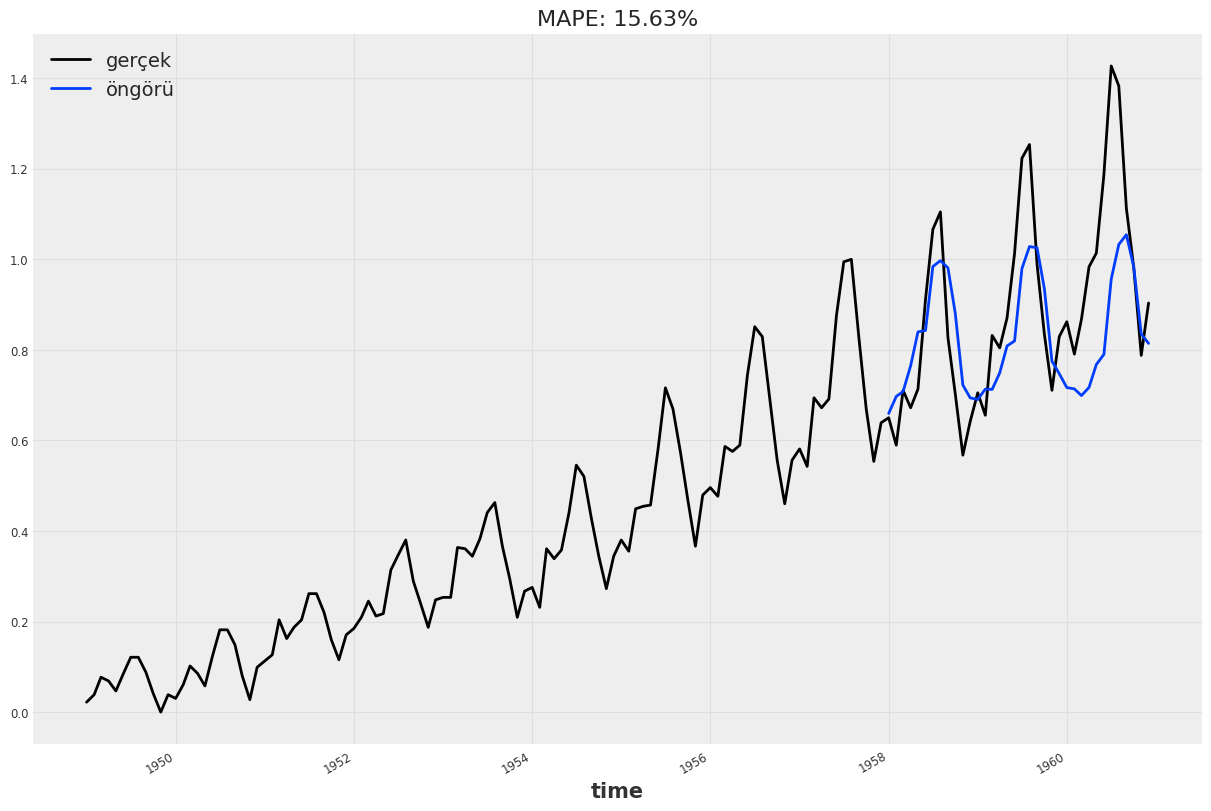

In [45]:
def model_geliştirme(model, n, veri, test_verisi):
    
    öngörü = model.predict(n=n)
    plt.figure(figsize=(12, 8))
    veri.plot(label="gerçek")
    öngörü.plot(label="öngörü")
    plt.title("MAPE: {:.2f}%".format(mape(öngörü, test_verisi)))
    plt.legend()


model_geliştirme(model, 36, ölçeklenmiş_veri, ölçeklenmiş_test_verisi)